# setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

from tensorflow.python.keras.utils.data_utils import Sequence

sklearn version:  0.24.2
TF version:  2.8.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


# Get the data

In [2]:
#작성자 전민재, hsh
import csv
def load_Emist(exsitNumpy=False, needTranspose=True):
    if (exsitNumpy == False):
        #"./emnist-byclass-test.csv"
        #train-set
        #"공용/datasets/Emnist/" 위치에 csv 저장 
        csv_train_data_file = open("../공용/datasets/Emnist/train_data.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        csv_train_label_file = open("../공용/datasets/Emnist/train_label.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
    
        
        f_train = csv.reader(csv_train_data_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        l_train=csv.reader(csv_train_label_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        #valid-set
    
        csv_valid_data_file = open("../공용/datasets/Emnist/valid_data.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        csv_valid_label_file = open("../공용/datasets/Emnist/valid_label.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        
        f_valid = csv.reader(csv_valid_data_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        l_valid = csv.reader(csv_valid_label_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        X_train=[]
        y_train=[]
        X_valid=[]
        y_valid=[]
        for i, row in enumerate(f_train):
            #행마다 int로 형변환
            for idx, char in enumerate(row):
                row[idx]=int(char)
            #train
            #data 추가    
            X_train.append(row)
            
        for i, row in enumerate(f_valid):
            #행마다 int로 형변환
            for idx, char in enumerate(row):
                row[idx]=int(char)
            #valid
            #data 추가    
            X_valid.append(row)


        for i, row in enumerate(l_train):

            #train
            #label 추가
            y_train.append(int(row[0]))
            
        for i, row in enumerate(l_valid):

            #valid
            #label 추가
            y_valid.append(int(row[0]))
            
            
        

        #train
        X_train=np.array(X_train,dtype=np.uint8)
        X_train=X_train.reshape(-1,28,28)
        #valid
        X_valid=np.array(X_valid,dtype=np.uint8)
        X_valid=X_valid.reshape(-1,28,28)
        
        csv_train_data_file.close()
        csv_train_label_file.close()
        csv_valid_data_file.close()
        csv_valid_label_file.close()
        
        #kaggle dataset이 시계반대방향으로 90도 회전 되있고 상하 반전 되어있음
        def rotate_90(m):
            N = len(m)
            ret = [[0] * N for _ in range(N)]

            for r in range(N):
                for c in range(N):
                    ret[c][N-1-r] = m[r][c]
            return np.array(ret,dtype=np.uint8)

        def vreflect(m):
            N = len(m)
            ret = [[0] * N for _ in range(N)]

            for r in range(N):
                for c in range(N):
                    ret[r][c] = m[r][N-1-c]
            return np.array(ret,dtype=np.uint8)
        
        if needTranspose == True:
            #train
            #회전
            for idx,i in enumerate(X_train):
                X_train[idx]=rotate_90(i)
            #상하반전
            for idx,i in enumerate(X_train):
                X_train[idx]=vreflect(i)

            #valid
            #회전
            for idx,i in enumerate(X_valid):
                X_valid[idx]=rotate_90(i)
            #상하반전
            for idx,i in enumerate(X_valid):
                X_valid[idx]=vreflect(i)

       
        
        
        #저장용
        #train
        #(533917,28,28)
        
        np.save('../공용/X_train',np.array(X_train,dtype=np.uint8))
        np.save('../공용/y_train',np.array(y_train,dtype=np.uint8))
        #valid
        np.save('../공용/X_valid',np.array(X_valid,dtype=np.uint8))
        np.save('../공용/y_valid',np.array(y_valid,dtype=np.uint8))
        
   
    X_train=np.load('../공용/X_train.npy')
    y_train=np.load('../공용/y_train.npy')
    X_valid=np.load('../공용/X_valid.npy')
    y_valid=np.load('../공용/y_valid.npy')
    
    return X_train, y_train, X_valid, y_valid


In [3]:
#황성현
#npy 파일이 존재할 경우 exsitNumpy = True, 업으면 False
X_train, y_train, X_valid, y_valid = load_Emist(exsitNumpy=True)
X_train.shape,X_train.dtype

((533917, 28, 28), dtype('uint8'))

In [4]:
#황성현
X_train=tf.reshape(X_train,[-1,28,28,1])
X_valid=tf.reshape(X_valid,[-1,28,28,1])

In [5]:
#황성현,jmj
X_train.shape,X_valid.shape,X_train.dtype

(TensorShape([533917, 28, 28, 1]), TensorShape([164015, 28, 28, 1]), tf.uint8)

In [6]:
#황성현, jmj
X_train_resize=np.uint8(tf.image.resize(X_train, [32, 32]))
X_valid_resize=np.uint8(tf.image.resize(X_valid, [32, 32]))


In [7]:
#황성현
X_train_resize.shape,X_valid_resize.dtype,X_valid_resize.shape

((533917, 32, 32, 1), dtype('uint8'), (164015, 32, 32, 1))

# train the model

In [8]:
#황성현
class Inveted_Residual_Block(keras.layers.Layer):
    def __init__(self,c,s=1,t=1,n=1,**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.layers.ReLU(max_value=6)
        self.main_layers = [
            
            ]
        self.strides_layers=[
           ]
        self.s=s
        self.t=t
        self.c=c
        self.n=n
        
    def build(self,batch_input_shape):
        print(self.name,": batch_input_shape =",batch_input_shape)
        
        self.main_layers = [
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1, 
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=1,padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c,kernel_size=1, strides=1,padding="SAME", activation=self.activation),
            ]
        self.strides_layers=[
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1,
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=self.s,padding="SAME",activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c, kernel_size=1,strides=1,padding="SAME",activation=self.activation),
        ]

    def call(self, inputs):
        Z = inputs
        
        for n in range(0,self.n):
            if n == 0:
                for layer in self.strides_layers:
                    Z = layer(Z)
            else:
                skip_Z = Z
                for layer in self.main_layers:
                    Z = layer(Z)
                
                Z += skip_Z
    
        return Z
    
    def get_config(self):
        base=super().get_config()
        return{**base,"s":self.s,"t":self.t,"c":self.c,"n":self.n}

# fine tuning

# smv2l when batch_size=64, lr=0.002 by minsung

In [9]:
#황성현
n_classes=62
smv2_l=keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=[32,32,1]),
    keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
    Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
    Inveted_Residual_Block(t=4,c=16,n=2,s=2,name="IRB2"),
    Inveted_Residual_Block(t=8,c=32,n=2,s=2,name="IRB3"),
    Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB4"),
    Inveted_Residual_Block(t=8,c=128,n=1,s=2,name="IRB5"),
    Inveted_Residual_Block(t=8,c=1024,n=1,s=1,name="IRB6"),
    keras.layers.ReLU(max_value=6),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_classes,activation="softmax")
])
smv2_l.summary()

IRB1 : batch_input_shape = (None, 16, 16, 32)
IRB2 : batch_input_shape = (None, 16, 16, 16)
IRB3 : batch_input_shape = (None, 8, 8, 16)
IRB4 : batch_input_shape = (None, 4, 4, 32)
IRB5 : batch_input_shape = (None, 2, 2, 64)
IRB6 : batch_input_shape = (None, 1, 1, 128)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 IRB1 (Inveted_Residual_Bloc  (None, 16, 16, 16)       2288      
 k)                                                              
                                                                 
 IRB2 (Inveted_Residual_Bloc  (None, 8, 8, 16)     

In [10]:
opt = tf.keras.optimizers.Nadam(learning_rate=0.002)
batch_size=64
smv2_l.compile(loss="sparse_categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

In [11]:
#황성현 
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2L_batch_64_lr_002%Y%m%d-%H%M%S")
print(logs)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

check_cb=tf.keras.callbacks.ModelCheckpoint(filepath="SMV2L_batch_64_lr_002.h5",save_best_only=True)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history=smv2_l.fit(X_train_resize,y_train, batch_size = batch_size,
                    validation_data=(X_valid_resize,y_valid),
                    epochs=300,callbacks=[tboard_callback, check_cb, earlystop_cb])

logs/SMV2L_batch_64_lr_00220220602-143045
Epoch 1/300
8343/8343 [==============================] - 587s 69ms/step - loss: 0.7260 - accuracy: 0.7698 - val_loss: 0.5258 - val_accuracy: 0.8208
Epoch 2/300
8343/8343 [==============================] - 579s 69ms/step - loss: 0.4755 - accuracy: 0.8330 - val_loss: 0.4615 - val_accuracy: 0.8378
Epoch 3/300
8343/8343 [==============================] - 571s 68ms/step - loss: 0.4398 - accuracy: 0.8432 - val_loss: 1.2580 - val_accuracy: 0.6337
Epoch 4/300
8343/8343 [==============================] - 573s 69ms/step - loss: 0.4217 - accuracy: 0.8484 - val_loss: 0.4176 - val_accuracy: 0.8482
Epoch 5/300
8343/8343 [==============================] - 571s 68ms/step - loss: 0.4116 - accuracy: 0.8514 - val_loss: 0.4106 - val_accuracy: 0.8513
Epoch 6/300
8343/8343 [==============================] - 569s 68ms/step - loss: 0.4034 - accuracy: 0.8532 - val_loss: 0.4129 - val_accuracy: 0.8513
Epoch 7/300
8343/8343 [==============================] - 571s 68ms/ste

# smv2l when batch_size=256, lr=0.008 by minsung

In [12]:
#황성현
n_classes=62
smv2_l=keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=[32,32,1]),
    keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
    Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
    Inveted_Residual_Block(t=4,c=16,n=2,s=2,name="IRB2"),
    Inveted_Residual_Block(t=8,c=32,n=2,s=2,name="IRB3"),
    Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB4"),
    Inveted_Residual_Block(t=8,c=128,n=1,s=2,name="IRB5"),
    Inveted_Residual_Block(t=8,c=1024,n=1,s=1,name="IRB6"),
    keras.layers.ReLU(max_value=6),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_classes,activation="softmax")
])
smv2_l.summary()

IRB1 : batch_input_shape = (None, 16, 16, 32)
IRB2 : batch_input_shape = (None, 16, 16, 16)
IRB3 : batch_input_shape = (None, 8, 8, 16)
IRB4 : batch_input_shape = (None, 4, 4, 32)
IRB5 : batch_input_shape = (None, 2, 2, 64)
IRB6 : batch_input_shape = (None, 1, 1, 128)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 32, 32, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 IRB1 (Inveted_Residual_Bloc  (None, 16, 16, 16)       2288      
 k)                                                              
                                                                 
 IRB2 (Inveted_Residual_Bloc  (None, 8, 8, 16)   

In [13]:
opt = tf.keras.optimizers.Nadam(learning_rate=0.008)
batch_size=256
smv2_l.compile(loss="sparse_categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

In [14]:
#황성현 
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2L_batch_256_lr_008%Y%m%d-%H%M%S")
print(logs)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

check_cb=tf.keras.callbacks.ModelCheckpoint(filepath="SMV2L_batch_256_lr_008.h5",save_best_only=True)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history=smv2_l.fit(X_train_resize,y_train, batch_size = batch_size,
                    validation_data=(X_valid_resize,y_valid),
                    epochs=300,callbacks=[tboard_callback, check_cb, earlystop_cb])

logs/SMV2L_batch_256_lr_00820220602-190651
Epoch 1/300
2086/2086 [==============================] - 160s 73ms/step - loss: 0.6668 - accuracy: 0.7869 - val_loss: 0.5703 - val_accuracy: 0.8090
Epoch 2/300
2086/2086 [==============================] - 151s 72ms/step - loss: 0.4653 - accuracy: 0.8358 - val_loss: 0.4996 - val_accuracy: 0.8281
Epoch 3/300
2086/2086 [==============================] - 150s 72ms/step - loss: 0.4572 - accuracy: 0.8385 - val_loss: 0.5586 - val_accuracy: 0.8066
Epoch 4/300
2086/2086 [==============================] - 151s 72ms/step - loss: 0.4562 - accuracy: 0.8384 - val_loss: 0.4856 - val_accuracy: 0.8300
Epoch 5/300
2086/2086 [==============================] - 150s 72ms/step - loss: 0.4608 - accuracy: 0.8371 - val_loss: 0.7395 - val_accuracy: 0.7623
Epoch 6/300
2086/2086 [==============================] - 150s 72ms/step - loss: 0.4745 - accuracy: 0.8333 - val_loss: 1.1084 - val_accuracy: 0.6760
Epoch 7/300
2086/2086 [==============================] - 150s 72ms/st

In [2]:
%load_ext tensorboard
%tensorboard --logdir logs/SMV2L_batch_256_lr_00820220602-190651


Reusing TensorBoard on port 6006 (pid 1488), started 0:00:54 ago. (Use '!kill 1488' to kill it.)

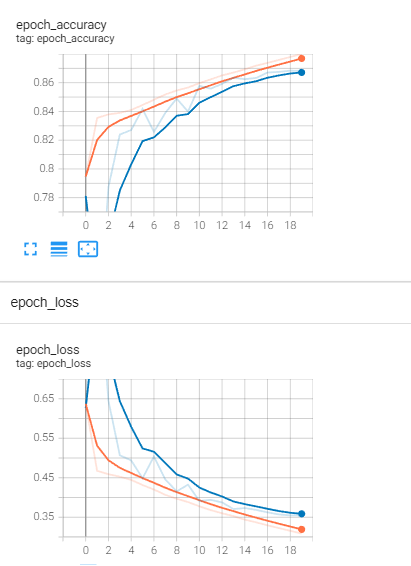

# smv2l when batch_size=256, lr=0.008, exp shed by seonghyun, minsung

In [27]:
#황성현
n_classes=62
smv2_l=keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=[32,32,1]),
    keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
    Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
    Inveted_Residual_Block(t=4,c=16,n=2,s=2,name="IRB2"),
    Inveted_Residual_Block(t=8,c=32,n=2,s=2,name="IRB3"),
    Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB4"),
    Inveted_Residual_Block(t=8,c=128,n=1,s=2,name="IRB5"),
    Inveted_Residual_Block(t=8,c=1024,n=1,s=1,name="IRB6"),
    keras.layers.ReLU(max_value=6),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_classes,activation="softmax")
])
smv2_l.summary()

IRB1 : batch_input_shape = (None, 16, 16, 32)
IRB2 : batch_input_shape = (None, 16, 16, 16)
IRB3 : batch_input_shape = (None, 8, 8, 16)
IRB4 : batch_input_shape = (None, 4, 4, 32)
IRB5 : batch_input_shape = (None, 2, 2, 64)
IRB6 : batch_input_shape = (None, 1, 1, 128)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  (None, 32, 32, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 IRB1 (Inveted_Residual_Bloc  (None, 16, 16, 16)       2288      
 k)                                                              
                                                                 
 IRB2 (Inveted_Residual_Bloc  (None, 8, 8, 16)   

In [28]:
opt = tf.keras.optimizers.Nadam(learning_rate=0.008)
batch_size=256
smv2_l.compile(loss="sparse_categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

In [29]:
#황성현 
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2L_batch_256_lr_008_sch_exp%Y%m%d-%H%M%S")
print(logs)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
check_cb=tf.keras.callbacks.ModelCheckpoint(filepath="SMV2L_batch_256_lr_008_sch_exp.h5",save_best_only=True)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history=smv2_l.fit(X_train_resize,y_train, batch_size = batch_size,
                    validation_data=(X_valid_resize,y_valid),
                    epochs=300,callbacks=[tboard_callback, check_cb, earlystop_cb,lr_callback])

logs/SMV2L_batch_256_lr_008_sch_exp20220603-141555
Epoch 1/300
2086/2086 [==============================] - 160s 73ms/step - loss: 0.6435 - accuracy: 0.7917 - val_loss: 0.5713 - val_accuracy: 0.8068 - lr: 0.0080
Epoch 2/300
2086/2086 [==============================] - 151s 72ms/step - loss: 0.4684 - accuracy: 0.8347 - val_loss: 0.6150 - val_accuracy: 0.7970 - lr: 0.0080
Epoch 3/300
2086/2086 [==============================] - 150s 72ms/step - loss: 0.4476 - accuracy: 0.8409 - val_loss: 0.4937 - val_accuracy: 0.8211 - lr: 0.0072
Epoch 4/300
2086/2086 [==============================] - 151s 72ms/step - loss: 0.4338 - accuracy: 0.8446 - val_loss: 0.4591 - val_accuracy: 0.8385 - lr: 0.0065
Epoch 5/300
2086/2086 [==============================] - 151s 72ms/step - loss: 0.4184 - accuracy: 0.8490 - val_loss: 0.4832 - val_accuracy: 0.8327 - lr: 0.0059
Epoch 6/300
2086/2086 [==============================] - 151s 72ms/step - loss: 0.4067 - accuracy: 0.8521 - val_loss: 0.4578 - val_accuracy: 0.8

In [4]:
%tensorboard --logdir logs/SMV2L_batch_256_lr_008_sch_exp20220603-141555


Reusing TensorBoard on port 6006 (pid 9212), started 0:07:33 ago. (Use '!kill 9212' to kill it.)

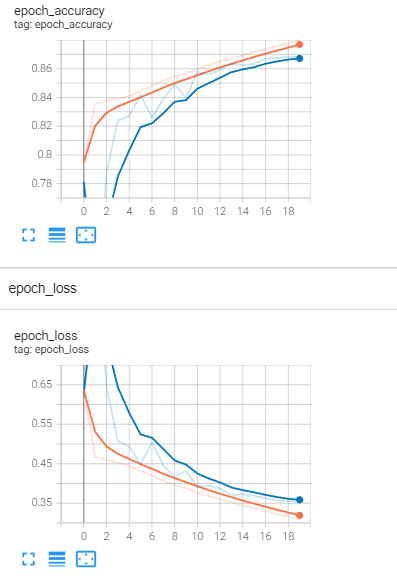